# Assessment of spatial coverage of SLSTR AOD (1°) for monitoring the spatial variability of wildfire-related AOD in Canada and Australia (2017–2023)

&nbsp;

Production date: 30-09-2024

Produced by: Consiglio Nazionale delle Ricerche ([CNR](https://www.cnr.it/en)- Fabio Madonna and Faezeh Karimian.)

## 🌍 Use case: AOD Increase due to Wildfires from Satellite Observations
## ❓ Quality assessment question
**• Can satellite AOD data consistently detect seasonal wildfire-driven aerosol peaks?**

**• Is the spatial coverage sufficient to study the spatial variability of wildfire-related AOD?**

In the context of climate change and increasing wildfire activity, understanding the spatial and temporal distribution of aerosols from biomass burning is essential for assessing their environmental and climatic impacts. Seasonal variations in Aerosol Optical Depth (AOD) are strongly influenced by large-scale wildfires, such as those recently observed in Canada and Australia, which can inject smoke into the upper troposphere and even the lower stratosphere, with consequences for air quality, radiative forcing, and atmospheric circulation [1, 2, 3]. However, uncertainties in satellite data, including temporal consistency and retrieval sensitivity under dense smoke conditions, may affect the accuracy of such assessments [1].

This analysis uses the SLSTR aerosol ensemble product at Level-2 super-pixel resolution (10 × 10 km²), combining SDVV, ORAC, and Swansea retrievals through uncertainty-weighted averaging, to assess its capacity to consistently and homogeneously capture the seasonal and episodic variability of AOD in wildfire-affected regions. The core objective is to evaluate whether satellite observations can reliably detect the dynamics of aerosol emissions and transport linked to major fire events.

The dataset analyzed is the Climate Data Store (CDS) AOD product derived from the SLSTR instrument aboard Sentinel-3, offering monthly gridded AOD values at 550 nm and ~1° spatial resolution in NetCDF format, covering the period 2017–2023.

Here, the ability of SLSTR data to monitor fire-driven AOD variability is investigated in regions highly affected by wildfires, focusing on extreme fire seasons in Canada and Australia. The analysis considers both the seasonal patterns and the intensity of episodic events, aiming to determine whether current satellite-based products provide sufficient spatial and temporal resolution for reliable monitoring.

The results indicate that SLSTR-derived AOD estimates align with known fire activity patterns and are consistent with independent findings reported in the literature. This supports the use of SLSTR data as a valuable source for tracking wildfire-related aerosol dynamics on a global scale.

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset "Carbon dioxide data from 2002 to present derived from satellite observations" can be used to evaluate CO2 mean values, climatology and growth rate over the globe, hemispheres or large regions
* Caution should be exercised in certain regions (high latitudes, regions with frequent cloud cover, oceans) where data availability varies along the temporal coverage of the data set: this must be carefully considered when evaluating global or hemispheric information
* For data in high latitude regions or in regions with frequent cloud cover, users should consult uncertainty and quality flags as appropriate for their applications. In addition, for the years 2003-2008 only values over land are available, which has to be taken into account for possible applications of this dataset
```

## 📋 Methodology
The methodology adopted for the analysis is split into the following steps:

[](section-1)  
- Import all required libraries    

[](section-2)  
- Load the data and prepare the dataframe  
- Define required functions  

[](section-3)  
- Plot time series for Canada and Australia
- Spatial distribution of AOD550 over Australia and Canada
- AOD Variability at a Global scale
- Spatiotemporal evolution of smoke plumes

[](section-4)  
- Take-home message  


## 📈 Analysis and results
(section-1)=
### Choose the data to use and set up the code
#### Import all required libraries

In this section, we import all the relevant packages needed for running the notebook.

In [4]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import cartopy.feature as cfeature


(section-2)=
### Data Retrieval and Preparation

#### Load the data and prepare the dataframe

In [28]:
request = {
    "time_aggregation": "monthly_average",
    "variable": ["aerosol_optical_depth"],
    "sensor_on_satellite": ["slstr_on_sentinel_3a"], 
    "algorithm": "ens",
    "version": "v2_3",
    "format": "zip"
}

In [8]:
folder_path = "./aod_data"  

file_list = sorted([
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith('.nc')
])
print(f"Found {len(file_list)} .nc files")
for f in file_list[:5]:  
    print(f)

file_list = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')])
df_list = []

for file in file_list:
    ds = xr.open_dataset(file)
    timestamp = pd.to_datetime(os.path.basename(file)[:6], format='%Y%m')
    ds = ds.expand_dims({'time': [timestamp]})
    df = ds.to_dataframe().reset_index()
    df_list.append(df)

final_df = pd.concat(df_list, ignore_index=True)
final_df.replace(-999.0, pd.NA, inplace=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)
print(final_df)

Found 66 .nc files
./aod_data/201801-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
./aod_data/201802-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
./aod_data/201803-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
./aod_data/201804-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
./aod_data/201805-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
              time  latitude  longitude    AOD550  FM_AOD550  \
0       2018-01-01     -89.5     -179.5       NaN        NaN   
43192   2018-01-01      29.5      172.5  0.123682   0.049830   
43193   2018-01-01      29.5      173.5  0.116795   0.043411   
43194   2018-01-01      29.5      174.5  0.188018   0.079148   
43195   2018-01-01      29.5      175.5  0.058454   0.015076   
...            ...       ...        ...       ...        ...   
4233604 2023-06-01     -29.5     -175.5  0.076325   0.047782   
4233605 2023-06-01     -29.5 

#### Spatial and temporal definitions

To investigate the spatiotemporal variability of wildfire-driven aerosols, the dataset was filtered both temporally and geographically. A time window was defined from January 2018 to June 2023 to cover multiple fire seasons, including extreme events in Australia (2019–2020) and Canada (2021). Spatial subsetting was then applied to isolate two regions of interest: Australia (latitudes –45° to –10°, longitudes 110° to 155°) and Canada (latitudes 45° to 75°, longitudes –140° to –50°). These filters allow for a focused analysis of AOD patterns associated with wildfire activity in regions known for severe biomass burning episodes.

In [9]:
time_dict = {
    "start": "2018-01", 
    "stop": "2023-06"
}
# Geographic filtering for Australia and Canada
australia_df = final_df[(final_df['latitude'] >= -45) & (final_df['latitude'] <= -10) &
                        (final_df['longitude'] >= 110) & (final_df['longitude'] <= 155)]

canada_df = final_df[(final_df['latitude'] >= 45) & (final_df['latitude'] <= 75) &
                     (final_df['longitude'] >= -140) & (final_df['longitude'] <= -50)]

#### Define required functions

The following functions were defined to support the analysis of aerosol data:

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# ---- fill NaNs on the native grid (no regridding) ----
def _fill_nearest_2d(Z, n_iter=3):
    Z = Z.copy()
    for _ in range(n_iter):
        mask = np.isnan(Z)
        if not mask.any(): break
        Zpad = np.pad(Z, 1, mode="edge")
        nb = np.stack([
            Zpad[:-2,1:-1], Zpad[2:,1:-1], Zpad[1:-1,:-2], Zpad[1:-1,2:]
        ])
        Z[mask] = np.nanmean(nb, axis=0)[mask]
    return Z


def native_field_from_df(df, date, region, var="AOD550"):
    min_lon, max_lon, min_lat, max_lat = region
    date = pd.to_datetime(date)
    d = df.copy()
    if not np.issubdtype(d["time"].dtype, np.datetime64):
        d["time"] = pd.to_datetime(d["time"])
    if d["longitude"].max() > 180:
        d["longitude"] = ((d["longitude"] + 180) % 360) - 180

    d = d.loc[d["time"] == date, ["longitude","latitude",var]].dropna()
    d = d[d["longitude"].between(min_lon, max_lon) & d["latitude"].between(min_lat, max_lat)]
    if d.empty:
        raise ValueError(f"No {var} on {date.date()} in {region}")

    g = d.groupby(["latitude","longitude"], as_index=False)[var].mean()
    lats = np.sort(g["latitude"].unique())
    lons = np.sort(g["longitude"].unique())
    pivot = g.pivot(index="latitude", columns="longitude", values=var).reindex(index=lats, columns=lons)
    return np.array(pivot.columns), np.array(pivot.index), pivot.values

def plot_native_map(
    df, date, region, region_name, var="AOD550",
    vmin=0.0, vmax=0.6, levels=None, smooth_sigma=0.8,
    shapefile_path=None,
    lon_step=10, lat_step=5   # NEW
):
    if levels is None:
        levels = np.linspace(vmin, vmax, 13)

    lon, lat, Z = native_field_from_df(df, date, region, var)
    if np.isnan(Z).any():
        Z = _fill_nearest_2d(Z, n_iter=3)
    if smooth_sigma and smooth_sigma > 0:
        Z = gaussian_filter(Z, sigma=smooth_sigma)

    LON, LAT = np.meshgrid(lon, lat)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(region, crs=ccrs.PlateCarree())

    cf = ax.contourf(
        LON, LAT, Z, levels=levels, cmap="coolwarm",
        vmin=vmin, vmax=vmax, extend="both",
        transform=ccrs.PlateCarree()
    )

    if shapefile_path:
        reader = shpreader.Reader(shapefile_path)
        ax.add_geometries(reader.geometries(), crs=ccrs.PlateCarree(),
                          facecolor="none", edgecolor="black", linewidth=1.2)
    else:
        ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=1.2, edgecolor="black")
        ax.add_feature(cfeature.BORDERS.with_scale("10m"),   linewidth=0.6, edgecolor="gray")

    # Colorbar
    cbar = plt.colorbar(cf, ax=ax, pad=0.02, ticks=np.linspace(vmin, vmax, 7))
    cbar.set_label(var)


    min_lon, max_lon, min_lat, max_lat = region
    ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
    ax.set_xticks(np.arange(np.floor(min_lon/lon_step)*lon_step, np.ceil(max_lon/lon_step)*lon_step + 0.1, lon_step), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(min_lat/lat_step)*lat_step, np.ceil(max_lat/lat_step)*lat_step + 0.1, lat_step), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format=".0f", degree_symbol="°", direction_label=False))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format=".0f", degree_symbol="°", direction_label=False))

    ax.set_title(f"{var} – {region_name} – {pd.to_datetime(date).date()}")
    plt.tight_layout()
    plt.show()


(section-3)=
### Plot and describe the results

#### Plot time series for Canada an Australia 

This figure shows the monthly mean Aerosol Optical Depth (AOD550) time series for Australia and Canada between 2018 and mid-2023.

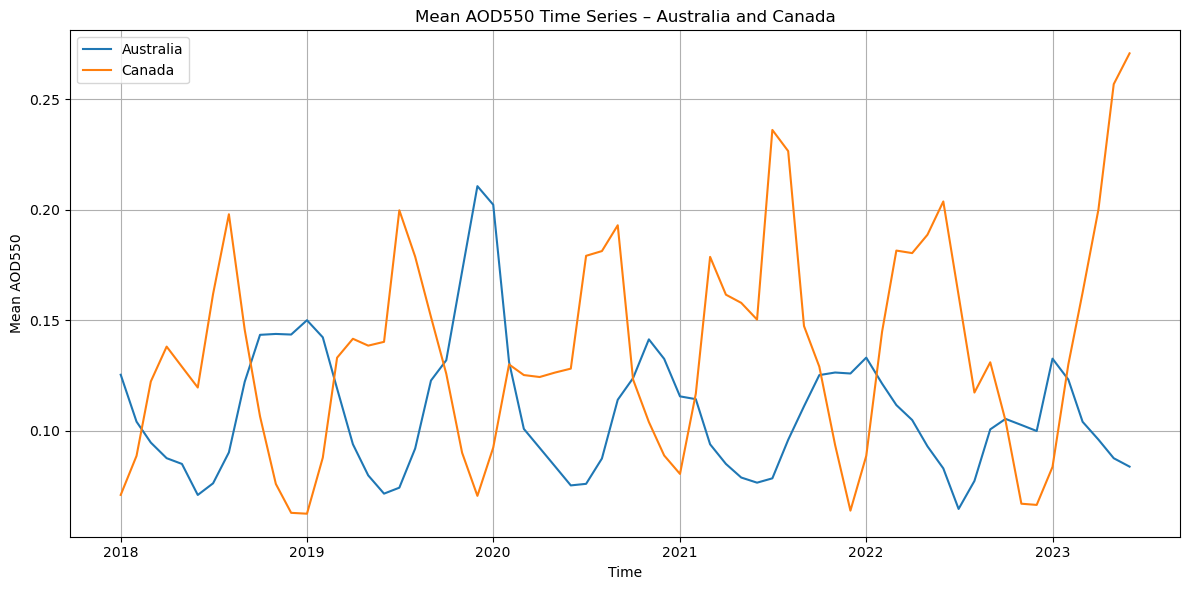

In [13]:
# Plot time series
plt.figure(figsize=(12, 6))
sns.lineplot(data=australia_df.groupby('time')['AOD550'].mean(), label='Australia')
sns.lineplot(data=canada_df.groupby('time')['AOD550'].mean(), label='Canada')

plt.title('Mean AOD550 Time Series – Australia and Canada')
plt.xlabel('Time')
plt.ylabel('Mean AOD550')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

*Figure 1.* Time series of monthly mean AOD550 for Australia and Canada over the 2017–2023 period. The plot highlights seasonal cycles and episodic peaks associated with major wildfire events, with AOD550 values consistently higher during fire seasons. In both regions, peaks align with reported extreme fire years described in the literature, demonstrating the capability of SLSTR data to capture the temporal evolution of biomass burning aerosol load.

#### Spatial distribution of AOD550 over Australia and Canada

These figures show the spatial distribution of AOD550 during major wildfire events in Australia (December 2019) and Canada (July 2021).

/data/wp5/.tmp/ipykernel_248202/554655943.py:16: RuntimeWarning: Mean of empty slice
  Z[mask] = np.nanmean(nb, axis=0)[mask]


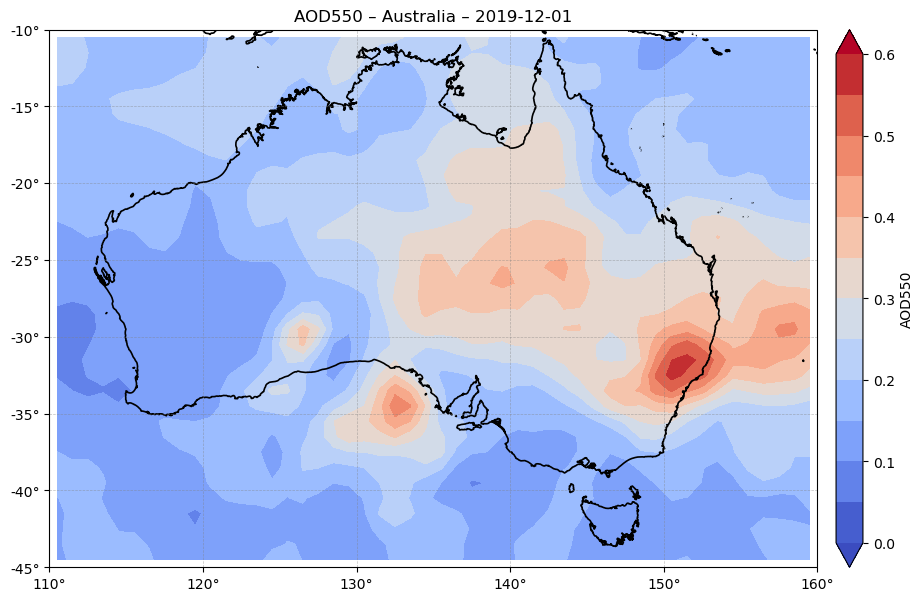

In [69]:
# Australia — DEC 2019 (matches the example month with higher AOD)
plot_native_map(
    final_df,
    date="2019-12-01",
    region=(110, 160, -45, -10),
    region_name="Australia",
    var="AOD550",
    vmin=0.0, vmax=0.6, smooth_sigma=0.8
)

*Figure 2.* Spatial distribution of AOD550 over Australia on 2019-12-01, derived from SLSTR (Sentinel-3) data at ~1° resolution. The map shows strong AOD enhancements along southeastern Australia, corresponding to the extreme bushfire season described in peer-reviewed studies and governmental fire reports for late 2019. These patterns are coherent with the seasonal and episodic peaks illustrated in Figure 1, confirming the dataset's ability to detect major wildfire-driven aerosol events [6].

/data/wp5/.tmp/ipykernel_248202/554655943.py:16: RuntimeWarning: Mean of empty slice
  Z[mask] = np.nanmean(nb, axis=0)[mask]


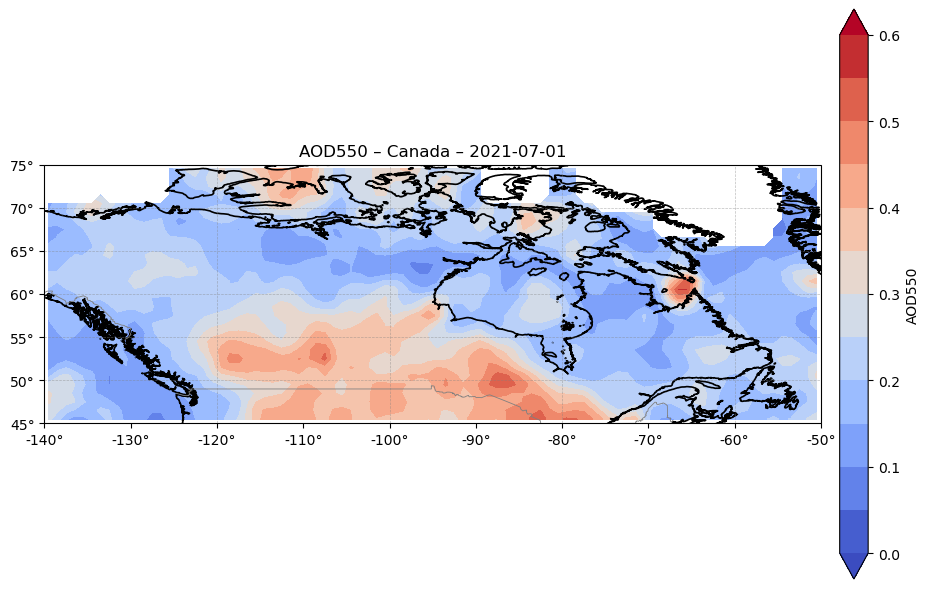

In [70]:
# Canada — JUL 2021
plot_native_map(
    final_df,
    date="2021-07-01",
    region=(-140, -50, 45, 75),
    region_name="Canada",
    var="AOD550",
    vmin=0.0, vmax=0.6, smooth_sigma=0.8
)


*Figure 3.* Spatial distribution of AOD550 over Canada on 2021-07-01, derived from SLSTR (Sentinel-3) data at ~1° resolution. The map highlights pronounced AOD enhancements over regions in central and western Canada, consistent with wildfire smoke plumes reported in the literature for this period. These elevated aerosol levels match the temporal peaks shown in Figure 1 and align with documented fire outbreaks in governmental and scientific fire records [5].

#### AOD Variability at global scale

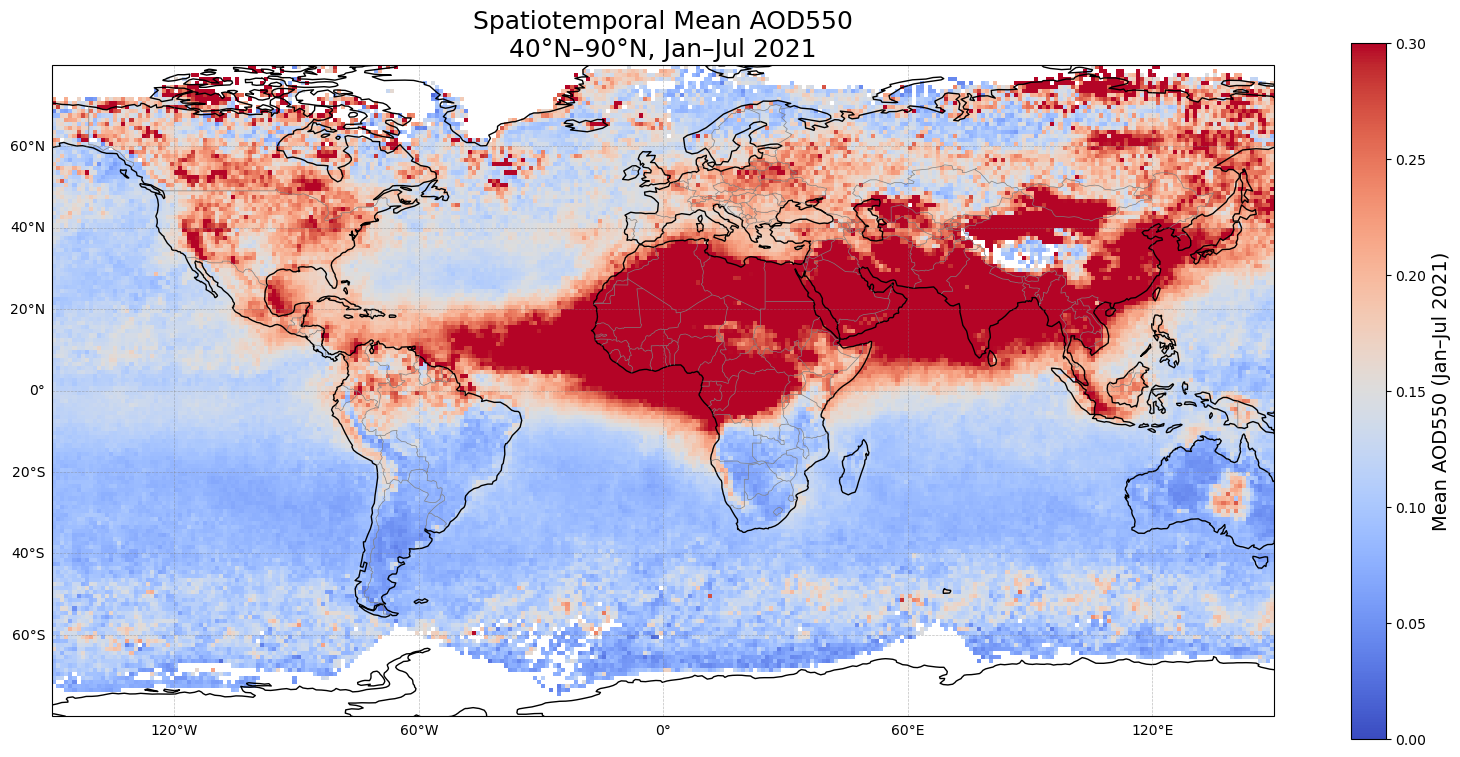

In [23]:

df = final_df.copy()
df['time'] = pd.to_datetime(df['time'])
df['AOD550'] = pd.to_numeric(df['AOD550'], errors='coerce')
df.replace(-999.0, np.nan, inplace=True)

# Filter: Jan–Jul 2021 and 40–90°N
mask = (
    (df['time'] >= '2021-01-01') & (df['time'] <= '2021-07-31') 
)
df_sel = df.loc[mask].dropna(subset=['AOD550'])

if df_sel.empty:
    print("No data after filtering — check your date/lat range or missing values.")
else:
    # Spatiotemporal mean on the native grid 
    g = (df_sel.groupby(['latitude','longitude'])['AOD550']
               .mean()
               .reset_index())

    # Build 2-D grid (rows=lat, cols=lon)
    lats = np.sort(g['latitude'].unique())
    lons = np.sort(g['longitude'].unique())
    grid = (g.pivot(index='latitude', columns='longitude', values='AOD550')
              .reindex(index=lats, columns=lons))
    Z = grid.values

    vmin, vmax = 0.0, 0.3
    levels = np.arange(vmin, vmax + 0.05, 0.05)

    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-150, 150, -80, 80], crs=ccrs.PlateCarree())

    LON, LAT = np.meshgrid(lons, lats)

    mesh = ax.pcolormesh(
        LON, LAT, Z,
        cmap='coolwarm', vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(), shading='auto'
    )


    ax.coastlines(resolution='110m', linewidth=1, color='black')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')


    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', shrink=0.8, ticks=levels)
    cbar.set_label("Mean AOD550 (Jan–Jul 2021)", fontsize=14)


    ax.set_title("Spatiotemporal Mean AOD550\n40°N–90°N, Jan–Jul 2021", fontsize=18)
    ax.set_xlabel("Longitude", fontsize=14)
    ax.set_ylabel("Latitude", fontsize=14)


    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

    plt.tight_layout()
    plt.show()


*Figure 4.* Global map of mean AOD550 for January–July 2021. Each point represents the spatial average at 1° resolution derived from SLSTR (Sentinel-3) data. Warm-colored points over Canada and Australia  mainly indicate regions with higher aerosol optical depth, reflecting smoke plumes and aerosol transport at the global scale. Biomass burning aerosols also affects the AOD over East Siberia. This complements the temporal analysis presented in Figures 1–3, providing context for the broader aerosol distribution.

#### Spatiotemporal evolution of smoke-plumes

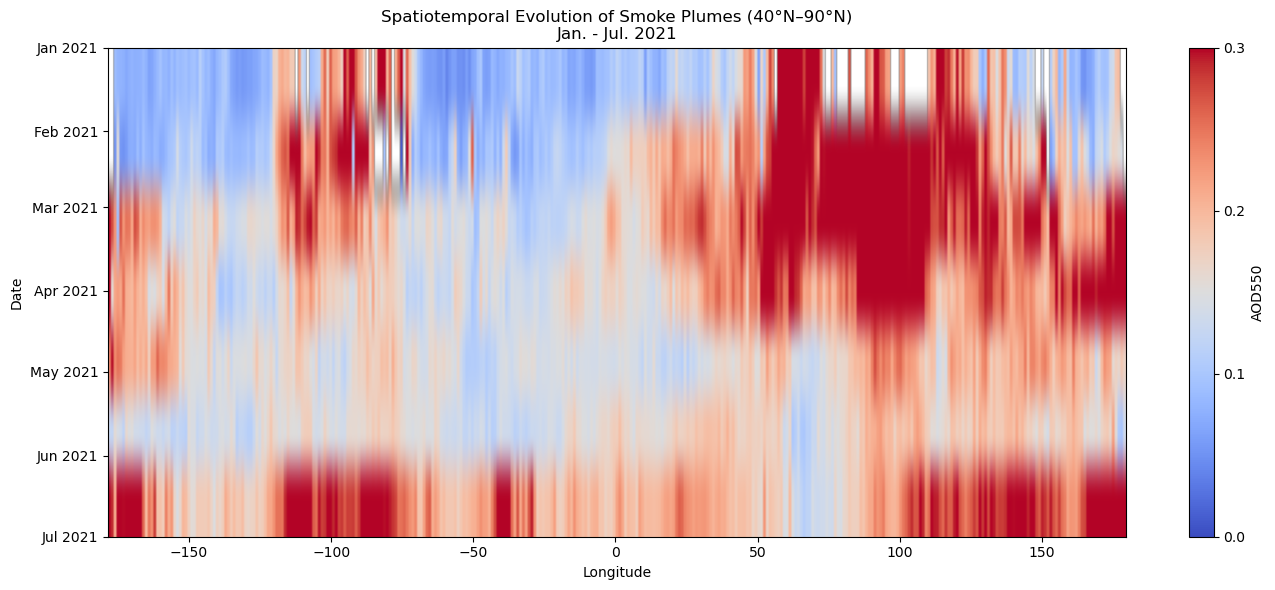

In [27]:
df_2022 = final_df[
    (final_df['latitude'] >= 40) & (final_df['latitude'] <= 90) &
    (final_df['time'] >= '2021-01-01') & (final_df['time'] <= '2021-07-01')
]

curtain_2022 = (
    df_2022.dropna(subset=['AOD550'])
    .groupby(['time', 'longitude'])['AOD550']
    .mean()
    .unstack()
)

vmin, vmax = 0.0, 0.3
levels = np.arange(vmin, vmax + 0.1, 0.1)

fig, ax = plt.subplots(figsize=(14, 6))
c = ax.imshow(curtain_2022, aspect='auto', cmap='coolwarm',
              vmin=vmin, vmax=vmax,
              extent=[curtain_2022.columns.min(), curtain_2022.columns.max(),
                      curtain_2022.index.max().toordinal(), curtain_2022.index.min().toordinal()])

cbar = plt.colorbar(c, label='AOD550', ax=ax, ticks=levels)
ax.set_title('Spatiotemporal Evolution of Smoke Plumes (40°N–90°N)\nJan. - Jul. 2021')
ax.set_xlabel('Longitude')
ax.set_ylabel('Date')

ticks = pd.date_range('2021-01-01', '2021-07-01', freq='MS')
ax.set_yticks([d.toordinal() for d in ticks])
ax.set_yticklabels([d.strftime('%b %Y') for d in ticks])

plt.tight_layout()
plt.show()


*Figure 5.* Hovmöller diagram showing the spatiotemporal evolution of mean AOD550 between 
    January and July 2022 over 40°N–90°N. Enhanced aerosol loadings appear as warm-colored 
    bands, indicating smoke plumes transported across longitudes. These patterns align with 
documented wildfire activity peaks in North America during this period [6], as seen in Figures 1–3.

(section-4)=
### Take-Home Messages

- Consistency with Independent Datasets: SLSTR aerosol data shows good agreement with other ground-based and Copernicus datasets providing measurements of the AOD in the considered periods [5, 6]. This supports the reliability of SLSTR for global aerosol monitoring.
  
- Wildfire Event Detection: The AOD dataset captures both the occurrence of wildfire events and the evolution over time. Seasonal peaks in AOD (June-July 2021 in Canada and Decemeber 2019 in Australia) coincide with documented fire activity periods [5,6].

- Impact of Missing Data: Missing months (mainly in winter) in the longitude range **–100° to –80° have a small effect on the AOD global analysis for the period Jan.-Jul. 2021 and for the indentificaiton of areas where fires contributes to the AOD increase, according to event records.

- Spatiotemporal Patterns: Maps reveal clear transport pathways of smoke plumes [6].

- Climate Monitoring – SLSTR AOD can be used to monitor aerosol emissions from biomass burning at regional to global scales.

- Air Quality Assessment – Seasonal wildfire peaks are visible, providing valuable information for public health and environmental policies.

## ℹ️ If you want to know more
### Key Resources

• Aerosol properties gridded data from 1995 to present derived from satellite observations:

https://cds.climate.copernicus.eu/datasets/satellite-aerosol-properties?tab=overview

Code libraries used:

• C3S EQC custom function, c3s_eqc_automatic_quality_control, prepared by B-Open


### References

[1] Popp, T., et al. (2016). Development, production and evaluation of aerosol climate data records from European satellite observations (Aerosol_cci). Remote Sensing, 8(5), 421.
https://doi.org/10.3390/rs8050421

[2] Peterson, D. A., et al. (2018). Wildfire-driven thunderstorms cause a volcano-like stratospheric injection of smoke. npj Climate and Atmospheric Science, 1, 30.
https://doi.org/10.1038/s41612-018-0039-3

[3] Sogacheva, L., Denisselle, M., Kolmonen, P., Virtanen, T. H., & Dransfeld, S. (2022). Extended validation and evaluation of the OLCI–SLSTR Synergy aerosol product (SY_2_AOD) on Sentinel-3. Atmospheric Measurement Techniques.
https://amt.copernicus.org/articles/15/5289/2022/

[4] Garrigues, S., et al. (2023). Impact of assimilating NOAA VIIRS aerosol optical depth in CAMS: comparison with MODIS and analysis performance. Atmospheric Chemistry and Physics.
https://acp.copernicus.org/articles/23/10473/2023/

[5] Li, M., Shen, F. & Sun, X. 2019‒2020 Australian bushfire air particulate pollution and impact on the South Pacific Ocean. Sci Rep 11, 12288 (2021). https://doi.org/10.1038/s41598-021-91547-y

[6] https://atmosphere.copernicus.eu/wildfires-wreaked-havoc-2021-cams-tracked-their-impact